In [1]:
import numpy as np
import tensorflow as tf
import vgg16
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as image
 
sess = tf.Session()
 
opt_img = tf.Variable( tf.truncated_normal( [1,224,224,3],
                                        dtype=tf.float32,
                                        stddev=1e-1), name='opt_img' )
 
tmp_img = tf.clip_by_value( opt_img, 0.0, 255.0 )
vgg = vgg16.vgg16( tmp_img, 'vgg16_weights.npz', sess )
 
style_img = imread( 'style.png', mode='RGB' )
style_img = imresize( style_img, (224, 224) )
style_img = np.reshape( style_img, [1,224,224,3] )
 
content_img = imread( 'content.png', mode='RGB' )
content_img = imresize( content_img, (224, 224) )
content_img = np.reshape( content_img, [1,224,224,3] )
 
layers = [ 'conv1_1', 'conv1_2',
           'conv2_1', 'conv2_2',
           'conv3_1', 'conv3_2', 'conv3_3',
           'conv4_1', 'conv4_2', 'conv4_3',
           'conv5_1', 'conv5_2', 'conv5_3' ]
 
ops = [ getattr( vgg, x ) for x in layers ]
#print "ops", len(ops)
 
content_acts = sess.run( ops, feed_dict={vgg.imgs: content_img } )
style_acts = sess.run( ops, feed_dict={vgg.imgs: style_img} )


(1, 28, 28, 512)
content (1, 28, 28, 512) orig (1, 28, 28, 512)
cont Tensor("mul_65:0", shape=(), dtype=float32)


100%|██████████| 1/1 [00:03<00:00,  3.79s/it]

c  0.0  s  2.10497e+08  t  2.10497e+11


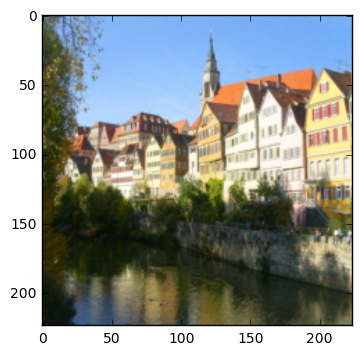

In [8]:
from tqdm import tqdm
#
# --- construct your cost function here
#

content_f = content_acts[-5]
print content_f.shape
img_content = vgg.conv4_2
print "content", content_f.shape, "orig", img_content.shape


content_loss = .5*tf.reduce_sum(tf.square(content_f - img_content))
print "cont", content_loss
# use standard error back prop using eq (2)

style_layers = [0,2,4,7,-3]
w_l = 1.0/len(style_layers)
c = .1

gram_style, gram_content = [], []
loss_style = []

def gram(t):
    dim = t.get_shape().as_list()
    t = tf.reshape(t, [dim[1]*dim[2], dim[3]])
    if(dim[1]*dim[2] < dim[3]):
        return tf.matmul(t, t, transpose_b=True)  
    else:
        return tf.matmul(t, t, transpose_a=True)

for i in style_layers:
    _, x, y, z = style_acts[i].shape # we don't need batch size
    M = x*y # feature map height by width
    N = z   # the number of filters
    style_f = tf.convert_to_tensor(style_acts[i], dtype=tf.float32)
    style_p = getattr(vgg, layers[i])
    g_style = gram(style_f)
    g_p = gram(style_p)
    #print (g_style.shape, g_p.shape)
    el = 1.0/(4*N**2*M**2)* tf.reduce_sum(tf.square(g_p-g_style))
    loss_style.append(el*w_l)

style_loss = tf.add_n(loss_style)

# Var list the noise
alpha = 1
beta = 1000
total_loss = alpha * content_loss + beta * style_loss

train_step = tf.train.AdamOptimizer(learning_rate=c).minimize(total_loss, var_list=[opt_img])


# this clobbers all VGG variables, but we need it to initialize the
# adam stuff, so we reload all of the weights...
sess.run( tf.global_variables_initializer() )
vgg.load_weights( 'vgg16_weights.npz', sess )
 
# initialize with the content image
sess.run( opt_img.assign( content_img ))
 
# --- place your optimization loop here
epoch_len = 1
for i in tqdm(xrange(epoch_len)):
    _, t_loss, s_loss, c_loss, im = sess.run([train_step, total_loss, style_loss, content_loss, opt_img])
    if i % 50 == 0:
        print "c ", c_loss, " s ", s_loss, " t ", t_loss 
        im_1 = sess.run(opt_img)
        image.imsave('image3/test_img_{}.png'.format(i), im_1[0]/255)

img_opt = sess.run(opt_img)
plt.imshow(img_opt.reshape(224,224,3)/255.0)
plt.show()
image.imsave('image3/final_img.png', img_opt[0]/255.0)

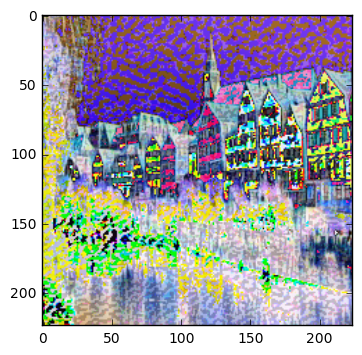

In [3]:
im = img_opt

plt.imshow(im.reshape((224,224,3)))
plt.show()